# Interior mixed problem

Remark: This notebook is essentially the mixed tutorial from Bempp.com applied to a an exponential problem and augmented with convergence/iteration analysis

## Problem statement

$$
\begin{equation}
\left\{ \begin{aligned} 
  -\Delta u = 0&,\;\;\Omega =[0,1]^3\\
  u = ze^{x}cos(y)&,\;\;0\leq z < 1\\
  \frac{\partial{u}}{\partial{n}} = (0, 0, e^{x}cos(y))&,\;\;z = 1
\end{aligned} \right.
\end{equation}
$$

### With exact solution:
$$
u(x, y, z) = ze^{x}cos(y)
$$

## Solving approach

Denote by $\Gamma_D$ the part of the boundary that holds the Dirichlet boundary conditions and by $\Gamma_N$ the boundary part that holds the Neumann boundary conditions. We denote by $t\in\Gamma_D$ the unknown Neumann data and by $u\in\Gamma_N$ the unknown Dirichlet data. The given Dirichlet data on $\Gamma_D$ is denoted by $g_D$ and the given Neumann data on $\Gamma_N$ is denoted by $g_N$.

From Green's representation theorem it follows that
$$
\begin{align}
\left[\mathsf{V}t\right] (\mathbf{x}) - \left[\mathsf{K}u\right] (\mathbf{x}) &= \left[\tfrac{1}{2}\mathsf{Id} + \mathsf{K}\right]g_D(\mathbf{x}) - \mathsf{V}g_N(\mathbf{x}),\quad \mathbf{x}\in\Gamma_D\\
\left[\mathsf{W}u\right] (\mathbf{x}) + \left[\mathsf{K}'t\right] (\mathbf{x}) &=\left[\tfrac{1}{2}\mathsf{Id} - \mathsf{K}'\right]g_N(\mathbf{x}) - \mathsf{W}g_D(\mathbf{x}),\quad \mathbf{x}\in\Gamma_N
\end{align}
$$

The difficulty in the implementation is the definition of the discrete function spaces and the treatment of degrees of freedom (dofs) that lie on the interface between $\Gamma_N$ and $\Gamma_D$. In the following, we will go through the implementation and point out how to correctly define all spaces involved.


### Data

In [1]:
from utils import Solvers
from utils.BC import BC
from utils.ConvergenceAnalysis import ConvergenceAnalysis

import bempp.api
import numpy as np
import matplotlib.pyplot as plt

import os

@bempp.api.real_callable
def dirichlet_data(x, n, domain_index, res):
    res[0] = x[2] * np.exp(x[0]) * np.cos(x[1])


@bempp.api.real_callable
def neumann_data(x, n, domain_index, res):
    if x[2] == 1:
        res[0] = 0
        res[1] = 0
        res[2] = np.exp(x[0]) * np.cos(x[1])


@bempp.api.real_callable
def f(x, n, d, res):
    res[0] = x[2] * np.exp(x[0]) * np.cos(x[1])


@bempp.api.real_callable
def g(x, n, d, res):
    res[0] = x[2] * np.exp(x[0]) * np.cos(x[1])
    res[1] = -x[2] * np.exp(x[0]) * np.sin(x[1])
    res[2] = np.exp(x[0]) * np.cos(x[1])

### Set domain, boundary conditions, function spaces and solve

In [2]:
## Domain
grid = bempp.api.shapes.cube(h=0.05)

## Boundary conitions and function spaces
neumann_BC = BC(space=("DP", 0), data=neumann_data, allocation=[6])
dirichlet_BC = BC(space=("P", 1), data=dirichlet_data, allocation=[1, 2, 3, 4, 5])


## Solve
neumann_sol, dirichlet_sol, global_neumann_space, global_dirichlet_space, it = (
    Solvers.mixed(
        grid,
        neumann_BC,
        dirichlet_BC,
    )
)

### Create evaluation points and associated operators

In [ ]:
## Define number and position of points
n_grid_points = 150
plot_grid = np.mgrid[0 : 1 : n_grid_points * 1j, 0 : 1 : n_grid_points * 1j]
points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.ones(plot_grid[0].size) / 2)
)

## Define the operators to map the function space of ___ to that of the points
slp_pot = bempp.api.operators.potential.laplace.single_layer(
    global_neumann_space, points
)
dlp_pot = bempp.api.operators.potential.laplace.double_layer(
    global_dirichlet_space, points
)

## Produce inner solution via ___
u_evaluated = slp_pot * neumann_sol - dlp_pot * dirichlet_sol

In [ ]:
bempp.api.export(
    "exponential.msh", grid_function=dirichlet_sol
)

## Can comment this out if you do not want to plot the boundary solution or Gmsh is not installed
os.system("gmsh 'exponential.msh'&")

## Convergence analysis results

In [5]:
grid = bempp.api.shapes.cube(h=0.05)

neumann_BC = BC(space=("P", 1), data=neumann_data, allocation=[6])
dirichlet_BC = BC(space=("DP", 1), data=dirichlet_data, allocation=[1, 2, 3, 4, 5])

h_values, ndofs, L2_p1_dp1, H1_p1_dp1, it_p1_dp1 = ConvergenceAnalysis.convergence_analysis_mixed(
    Solvers.mixed, neumann_BC, dirichlet_BC, g, f, 14
)
h_values = np.array(h_values)
h2 = h_values*h_values
h1 = h_values
h12 = (h_values**1.5)
h2 /= max(h2)
h1 /= max(h1)
h12 /= max(h12)

neumann_BC = BC(space=("DP", 0), data=neumann_data, allocation=[6])
dirichlet_BC = BC(space=("DP", 1), data=dirichlet_data, allocation=[1, 2, 3, 4, 5])

h_values, ndofs, L2_dp0_dp1, H1_dp0_dp1, it_dp0_dp1 = ConvergenceAnalysis.convergence_analysis_mixed(
    Solvers.mixed, neumann_BC, dirichlet_BC, g, f, 14
)

neumann_BC = BC(space=("P", 1), data=neumann_data, allocation=[6])
dirichlet_BC = BC(space=("P", 1), data=dirichlet_data, allocation=[1, 2, 3, 4, 5])

h_values, ndofs, L2_p1_p1, H1_p1_p1, it_p1_p1 = ConvergenceAnalysis.convergence_analysis_mixed(
    Solvers.mixed, neumann_BC, dirichlet_BC, g, f, 14
)

neumann_BC = BC(space=("DP", 0), data=neumann_data, allocation=[6])
dirichlet_BC = BC(space=("P", 1), data=dirichlet_data, allocation=[1, 2, 3, 4, 5])

h_values, ndofs, L2_dp0_p1, H1_dp0_p1, it_dp0_p1 = ConvergenceAnalysis.convergence_analysis_mixed(
    Solvers.mixed, neumann_BC, dirichlet_BC, g, f, 14
)

neumann_BC = BC(space=("DP", 1), data=neumann_data, allocation=[6])
dirichlet_BC = BC(space=("DP", 1), data=dirichlet_data, allocation=[1, 2, 3, 4, 5])

h_values, ndofs, L2_dp1_dp1, H1_dp1_dp1, it_dp1_dp1 = ConvergenceAnalysis.convergence_analysis_mixed(
    Solvers.mixed, neumann_BC, dirichlet_BC, g, f, 14
)

neumann_BC = BC(space=("DP", 1), data=neumann_data, allocation=[6])
dirichlet_BC = BC(space=("P", 1), data=dirichlet_data, allocation=[1, 2, 3, 4, 5])

h_values, ndofs, L2_dp1_p1, H1_dp1_p1, it_dp1_p1 = ConvergenceAnalysis.convergence_analysis_mixed(
    Solvers.mixed, neumann_BC, dirichlet_BC, g, f, 14
)

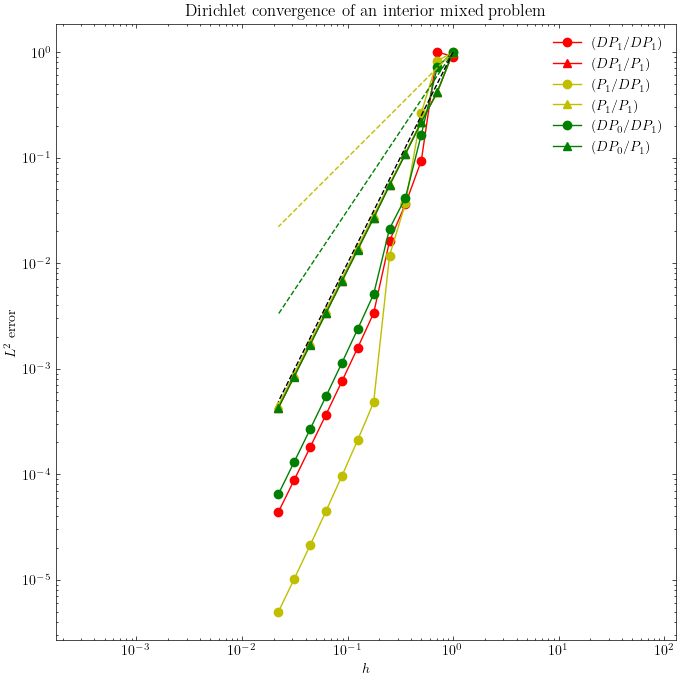

In [ ]:
import scienceplots
import matplotlib.pyplot as plt

with plt.style.context(['science', 'high-vis']):
    plt.figure(figsize = (8,8))
    plt.plot(h1, L2_dp1_dp1/max(L2_dp1_dp1), "ro-", label="$(DP_1 / DP_1)$")
    plt.plot(h1, L2_dp1_p1/max(L2_dp1_p1), "r^-", label="$(DP_1 / P_1)$")
    plt.plot(h1, L2_p1_dp1/max(L2_p1_dp1), "yo-", label="$(P_1 / DP_1)$")
    plt.plot(h1, L2_p1_p1/max(L2_p1_p1), "y^-", label="$(P_1 / P_1)$")
    plt.plot(h1, L2_dp0_dp1/max(L2_dp0_dp1), "go-", label="$(DP_0 / DP_1)$")
    plt.plot(h1, L2_dp0_p1/max(L2_dp0_p1), "g^-", label="$(DP_0 / P_1)$")
    plt.plot(h1, h1, "y--")
    plt.plot(h1, h12, "g--")
    plt.plot(h1,h2, "k--")
    plt.xlabel("$h$")
    plt.ylabel("$L^2$ error")
    plt.xscale("log")
    plt.yscale("log")
    plt.axis("equal")
    plt.legend()
    plt.title("Dirichlet convergence of an interior mixed problem")

    plt.show()

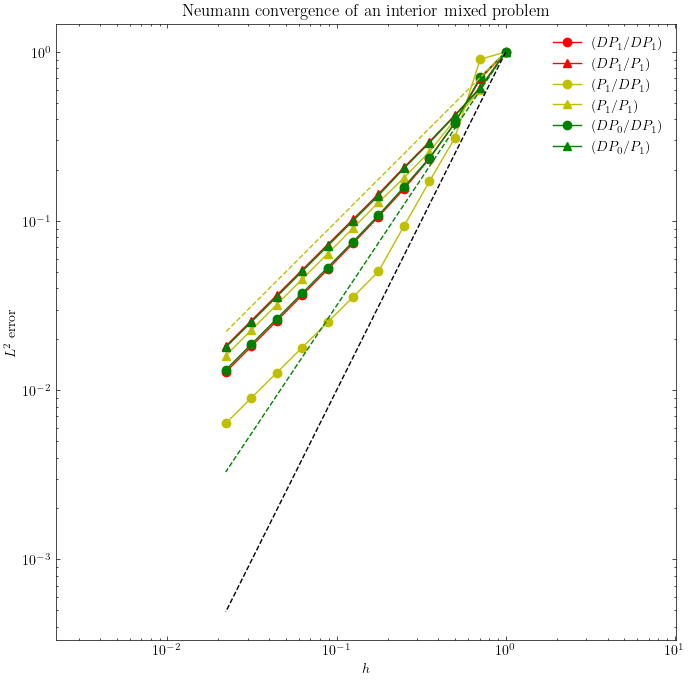

In [ ]:
with plt.style.context(['science', 'high-vis']):
    plt.figure(figsize = (8,8))
    plt.plot(h1, H1_dp1_dp1/max(H1_dp1_dp1), "ro-", label="$(DP_1 / DP_1)$")
    plt.plot(h1, H1_dp1_p1/max(H1_dp1_p1), "r^-", label="$(DP_1 / P_1)$")
    plt.plot(h1, H1_p1_dp1/max(H1_p1_dp1), "yo-", label="$(P_1 / DP_1)$")
    plt.plot(h1, H1_p1_p1/max(H1_p1_p1), "y^-", label="$(P_1 / P_1)$")
    plt.plot(h1, H1_dp0_dp1/max(H1_dp0_dp1), "go-", label="$(DP_0 / DP_1)$")
    plt.plot(h1, H1_dp0_p1/max(H1_dp0_p1), "g^-", label="$(DP_0 / P_1)$")
    plt.plot(h1, h1, "y--")
    plt.plot(h1, h12, "g--")
    plt.plot(h1,h2, "k--")
    plt.xlabel("$h$")
    plt.ylabel("$L^2$ error")
    plt.xscale("log")
    plt.yscale("log")
    plt.axis("equal")
    plt.legend()

    plt.title("Neumann convergence of an interior mixed problem")

    plt.show()

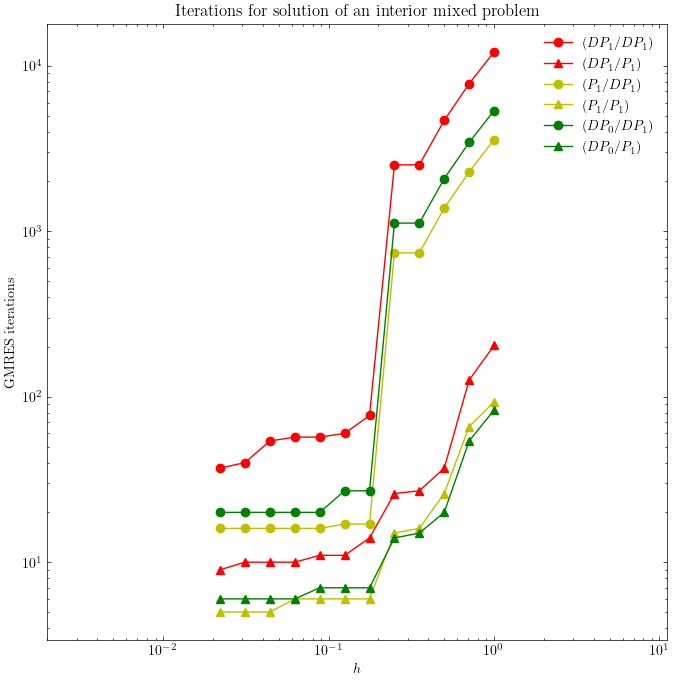

In [ ]:
with plt.style.context(['science']):
    plt.figure(figsize = (8,8))
    plt.plot(h1, it_dp1_dp1, "ro-", label="$(DP_1 / DP_1)$")
    plt.plot(h1, it_dp1_p1, "r^-", label="$(DP_1 / P_1)$")
    plt.plot(h1, it_p1_dp1, "yo-", label="$(P_1 / DP_1)$")
    plt.plot(h1, it_p1_p1, "y^-", label="$(P_1 / P_1)$")
    plt.plot(h1, it_dp0_dp1, "go-", label="$(DP_0 / DP_1)$")
    plt.plot(h1, it_dp0_p1, "g^-", label="$(DP_0 / P_1)$")
    plt.xlabel("$h$")
    plt.ylabel("GMRES iterations")
    plt.xscale("log")
    plt.yscale("log")
    plt.axis("equal")
    plt.legend()
    plt.xlim(plt.xlim()[::-1])
    plt.title("Iterations for solution of an interior mixed problem")
    plt.show()